In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import math
import matplotlib.pyplot as plt

from transformers.image_utils import load_image

device = 'cuda'

# Detection and segmentation tasks

We have already talked about using pretrained models to extract useful information from an image to solve detection or segmentation task. There are several ways to do that: 

- adapt some latent inner knowledge of a classifier or a generative (mostly diffusion) model;
- use a big unified model specifically pretrained for extraction meaningfull image embeddings (CLIP/DINO);
- take a closer look at attention layers;
- combine several of those and other methods at the same time.

## Attention scores and activations as object masks

Now we are going to focus on **attention layers**

It sound easy to "just look at the attention scores, they encode relations between image patches and text embeddings". However, how do we do that in practice? We will explore the inner parts of attention layers using Stable Diffusion model as a base.

It's architecture can be seen in the image:

<img src="https://miro.medium.com/v2/resize:fit:1400/1*CBzJPumf6tLktlNvhQVL4w.png">

In [3]:
from diffusers import StableDiffusionXLPipeline

pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0"
).to(device)

2025-10-20 17:54:54.636125: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 17:54:54.649149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-20 17:54:54.664170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-20 17:54:54.668606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-20 17:54:54.680380: I tensorflow/core/platform/cpu_feature_guar

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Let's change the default attention processers to custom ones, so we can save any information from the forward pass in our custom class

In [4]:
from handler import Handler

handler = Handler(pipeline)
attentions = handler.register()

In [5]:
attentions[:5]

['down_blocks.1.attentions.0.transformer_blocks.0.attn2.processor',
 'down_blocks.1.attentions.0.transformer_blocks.1.attn2.processor',
 'down_blocks.1.attentions.1.transformer_blocks.0.attn2.processor',
 'down_blocks.1.attentions.1.transformer_blocks.1.attn2.processor',
 'down_blocks.2.attentions.0.transformer_blocks.0.attn2.processor']

In [6]:
prompt = """
    A clean studio photograph of a few distinct everyday objects on a plain white background — 
    a red apple, a blue mug, a yellow notebook, and a green plant — arranged neatly on a table with soft lighting and no shadows
"""
output = pipeline(prompt, num_inference_steps=20)

  0%|          | 0/20 [00:00<?, ?it/s]

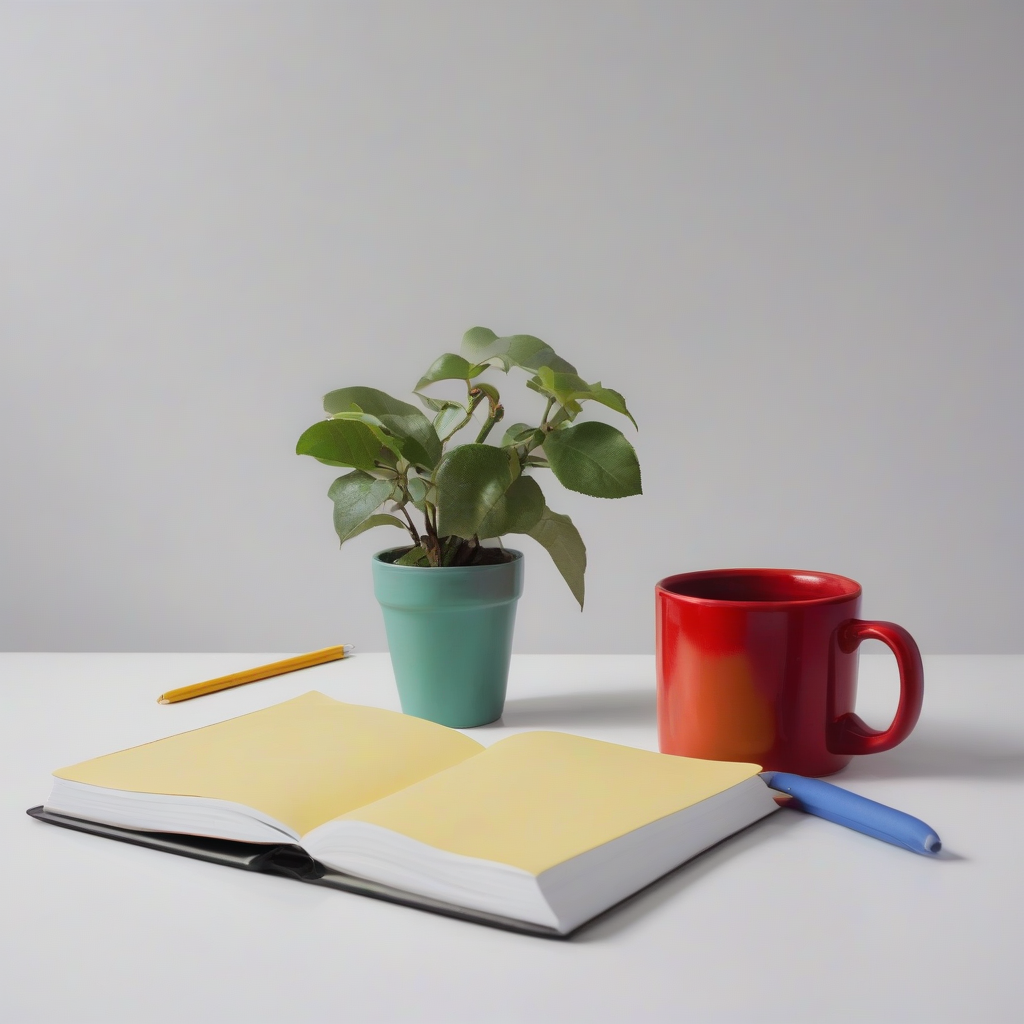

In [7]:
output.images[0]

In [8]:
handler.queries.keys()

dict_keys(['down_blocks.1.attentions.0.transformer_blocks.0.attn2.processor', 'down_blocks.1.attentions.0.transformer_blocks.1.attn2.processor', 'down_blocks.1.attentions.1.transformer_blocks.0.attn2.processor', 'down_blocks.1.attentions.1.transformer_blocks.1.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.0.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.1.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.2.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.3.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.4.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.5.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.6.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.7.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.8.attn2.processor', 'down_blocks.2.attentions.0.transformer_blocks.9.attn2.processor', 'down_blocks.2.attentions.1.transformer_blocks.0.at

In [9]:
layer = 'down_blocks.1.attentions.0.transformer_blocks.0.attn2.processor'
queries = handler.queries[layer]
queries[0].shape # (CFG, attention heads, latent patches, embed dim)

torch.Size([2, 10, 4096, 64])

Stable Diffusion model uses classifier-free guidance technique to do conditional generation. This requires parallel generation of null-text and user-defined prompt images, thus, despite our `batch_size=1`, in reality our model generates `2 * batch_size` samples every time. More information about CFG,can be 

In [10]:
queries = torch.stack(queries, dim=0)
queries.shape # (timesteps, CFG, attention heads, patches, embed dim)

torch.Size([20, 2, 10, 4096, 64])

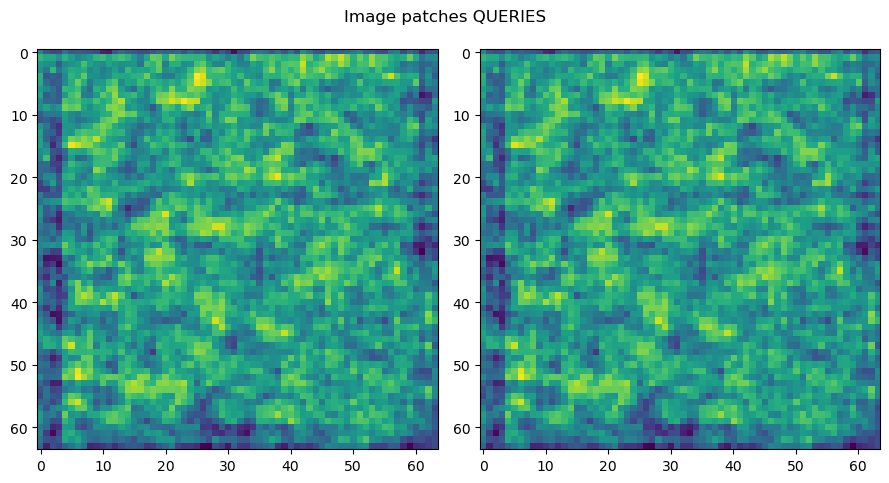

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

# we want to have a closer look at queries for conditional and null-prompt generation
for i in range(2):
    # mean across 5 initial timesteps, attention heads and embedding dim
    q = queries[:5, i].mean((0, 1, -1)).view(64, 64)
    axs[i].imshow(q)

plt.tight_layout()
plt.suptitle('Image patches QUERIES');

In [12]:
queries[:, 0].mean((0, 1, -1)) - queries[:, 1].mean((0, 1, -1))

tensor([0.0004, 0.0010, 0.0007,  ..., 0.0029, 0.0030, 0.0021])

As we can see, conditional and null-prompt generations are close but not the same. However, we can abuse this feature and accelerate the diffusion generation process reusing conditional features in null-prompt batch. This idea was researched in [FasterCache](https://arxiv.org/abs/2410.19355) paper.

Now let's look at the text-prompt keys.

In [13]:
handler.keys[layer][0].shape # (CFG, attention heads, tokens, embedding dim)

torch.Size([2, 10, 77, 64])

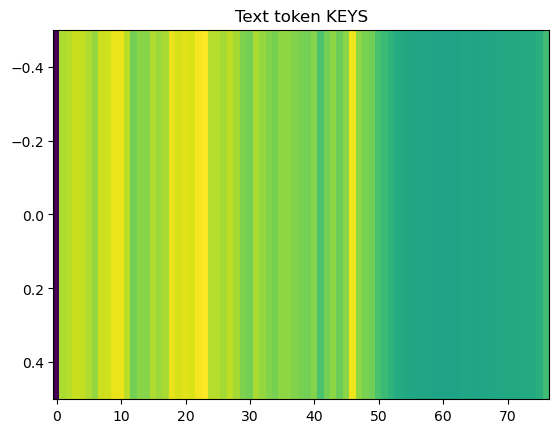

In [14]:
# meaned over timesteps, CFG batch and embedding dim
k = torch.concat(handler.keys[layer], dim=0).mean(dim=(0, 1, 3))

plt.imshow(k.unsqueeze(0), aspect='auto')
plt.title('Text token KEYS');

To solve detection problems, it is always more usefull to look at the attention scores or weights: those values represent the relation between image patch and token embedding.

In [15]:
def get_scores(query, key):
    scale_factor = 1 / math.sqrt(query.size(-1))
    
    attn_scores = query @ key.transpose(-2, -1) * scale_factor
    attn_weights = torch.softmax(attn_scores, dim=-1)
    return attn_scores, attn_weights

In [16]:
queries = torch.stack(handler.queries[layer], dim=0)
keys = torch.stack(handler.keys[layer], dim=0)

scores, weights = get_scores(queries, keys)

In [17]:
weights.shape # (timesteps, CFG, heads, image patches, text tokens)

torch.Size([20, 2, 10, 4096, 77])

In [18]:
# function to get the indexes of the text tokens we are interested in
def get_token_indexes(pipeline, prompt, object):
    object_tokens = pipeline.tokenizer(object).input_ids[1:-1]
    prompt_tokens = pipeline.tokenizer(prompt).input_ids
    
    occurance = next(idx for idx, token in enumerate(prompt_tokens) if token == object_tokens[0])
            
    start, end = occurance, occurance + len(object_tokens)
    object_tokens = [*range(start, end)]
    
    return prompt_tokens, object_tokens

In [19]:
prompt_tokens, object_tokens = get_token_indexes(pipeline, prompt, 'red apple')

In [20]:
object_tokens # function returns indexes of object tokens in input sequence

[18, 19]

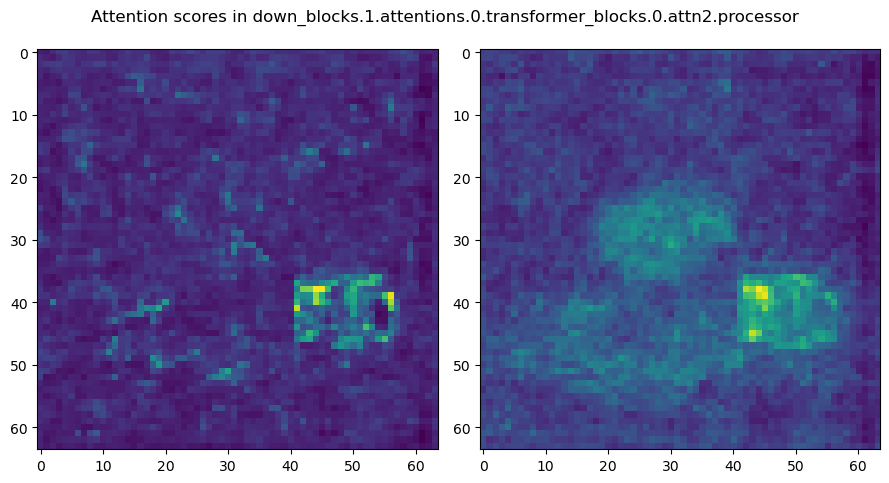

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

for i in range(2):
    # weights have shape
    # (timesteps, CFG, heads, image patches, text tokens)
    w = weights[:, 1, ..., object_tokens[i]].mean((0, 1)).view(64, 64)
    axs[i].imshow(w)

plt.tight_layout()
plt.suptitle(f'Attention scores in {layer}');

It is a common sence to look at middle layers of the UNet model to obtain any information aout object, because it is considered to be an information "bottle-neck" thus can be easier obtained from inner representations.

In [22]:
layer = 'mid_block.attentions.0.transformer_blocks.0.attn2.processor'

queries = torch.stack(handler.queries[layer], dim=0)
keys = torch.stack(handler.keys[layer], dim=0)

scores, weights = get_scores(queries, keys)

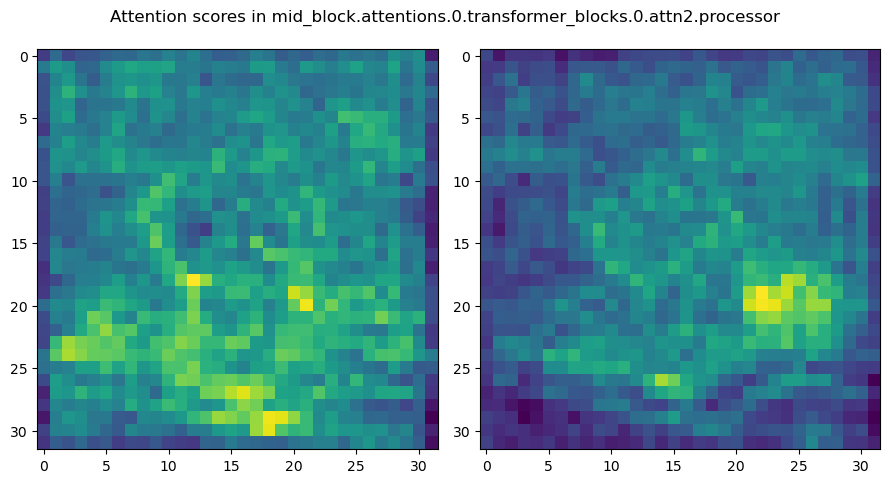

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

for i in range(2):
    # weights have shape
    # (timesteps, CFG, heads, image patches, text tokens)
    w = weights[:, 1, ..., object_tokens[i]].mean((0, 1)).view(32, 32) # be carefull, the number of patches here is different
    axs[i].imshow(w)

plt.tight_layout()
plt.suptitle(f'Attention scores in {layer}');

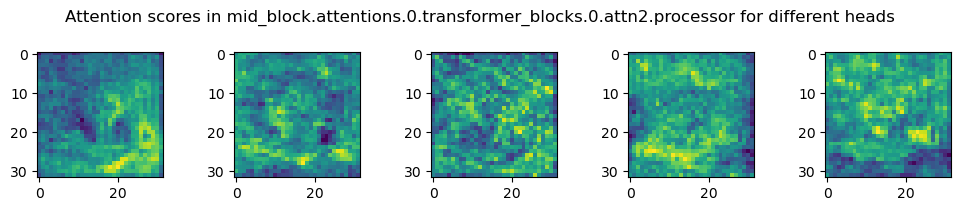

In [24]:
num_heads = 5
fig, axs = plt.subplots(1, num_heads, figsize=(10, 2))

for i in range(num_heads):
    axs[i].imshow(scores[:, 1, i, ..., object_tokens[1]].mean(0).view(32, 32))

plt.suptitle(f'Attention scores in {layer} for different heads');
plt.tight_layout()

Let's do the same but view the whole information about middle layers.

In [25]:
layers = [layer for layer in [*handler.queries.keys()] if 'mid' in layer]

queries, keys = [], []
for layer in layers:
    queries.append(torch.stack(handler.queries[layer], dim=0))
    keys.append(torch.stack(handler.keys[layer], dim=0))
    
queries[0].shape

torch.Size([20, 2, 20, 1024, 64])

In [26]:
queries = torch.stack(queries, dim=0)
keys = torch.stack(keys, dim=0)

queries.shape, keys.shape # (layers, timesteps, CFG, heads, patches/tokens, embedding dim)

(torch.Size([10, 20, 2, 20, 1024, 64]), torch.Size([10, 20, 2, 20, 77, 64]))

In [27]:
scores, weights = get_scores(queries[:, :, 1], keys[:, :, 1])
weights.shape

torch.Size([10, 20, 20, 1024, 77])

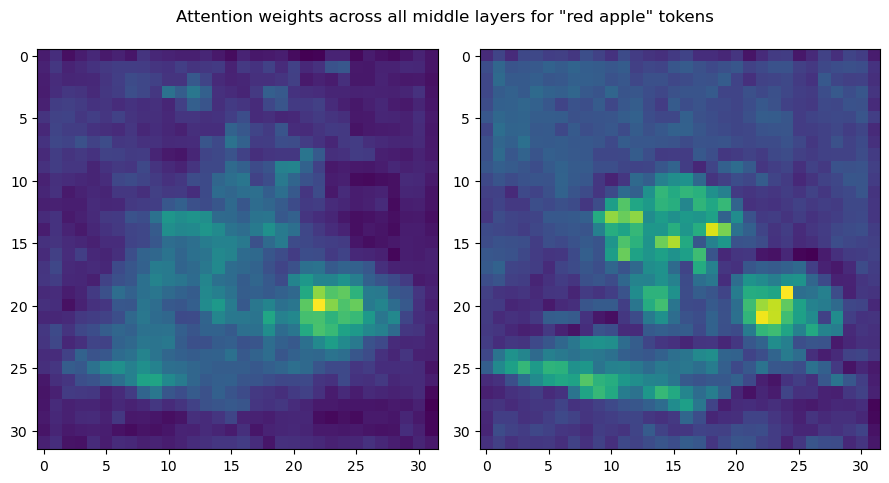

In [28]:
check_weights = [
    weights[:, :5, ...,  object_tokens[1]],
    weights[:, 5:, ..., object_tokens[1]]
]

fig, axs = plt.subplots(1, len(check_weights), figsize=(9, 5))
for i in range(len(check_weights)):
    axs[i].imshow(check_weights[i].mean(dim=(0, 1, 2)).view(32, 32))
    
plt.tight_layout()
plt.suptitle('Attention weights across all middle layers for "red apple" tokens');

Such object detection techniques are widely used in research. For example, there is a paper [ConceptAttention](https://arxiv.org/abs/2502.04320), where they obtain "high-quality saliency maps that precisely locate textual concepts within images" using attnetion layers information during the forward pass

The paper is based on FLUX model architecture: "There are two key classes of layers: one that keeps separate residual streams for each modality and one that uses a single stream. In this work, we take advantage of the properties of these dual stream layers, which we refer to as multi-modal attention layers (MMATTNs)".

You can also take a closer look at FLUX architecture diagram and a progression of attention layers through timesteps in the links provided ([first](https://www.reddit.com/r/LocalLLaMA/comments/1ekr7ji/fluxs_architecture_diagram_dont_think_theres_a/), [second](https://www.reddit.com/r/StableDiffusion/comments/1ilambe/this_is_what_fluxs_attention_looks_like/)).

<img src="https://github.com/helblazer811/ConceptAttention/raw/master/teaser.png">

[](https://www.reddit.com/r/LocalLLaMA/comments/1ekr7ji/fluxs_architecture_diagram_dont_think_theres_a/#lightbox)

# Pose estimation using pre-trained detection models

All previous setups use models that were pre-trained on other tasks to solve detection or segmentations tasks. But now, we wiil create an easy pipeline to use a detection model to do pose estimation. As a google AI mode says: "Pose estimation is a computer vision task that identifies key points on an object to determine its position and orientation in an image or video". Let's do that!

<img src="https://kemtai.com/wp-content/uploads/2022/12/65603fig.png">

In [29]:
from transformers import pipeline

checkpoint = "iSEE-Laboratory/llmdet_large"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

url = "https://thumbs.dreamstime.com/b/african-man-standing-happy-white-background-59852904.jpg"
image = load_image(url)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [30]:
# image

In [31]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)


predictions = detector(
    image,
    candidate_labels=["left shoulder"],
    threshold=0.45
)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="black")

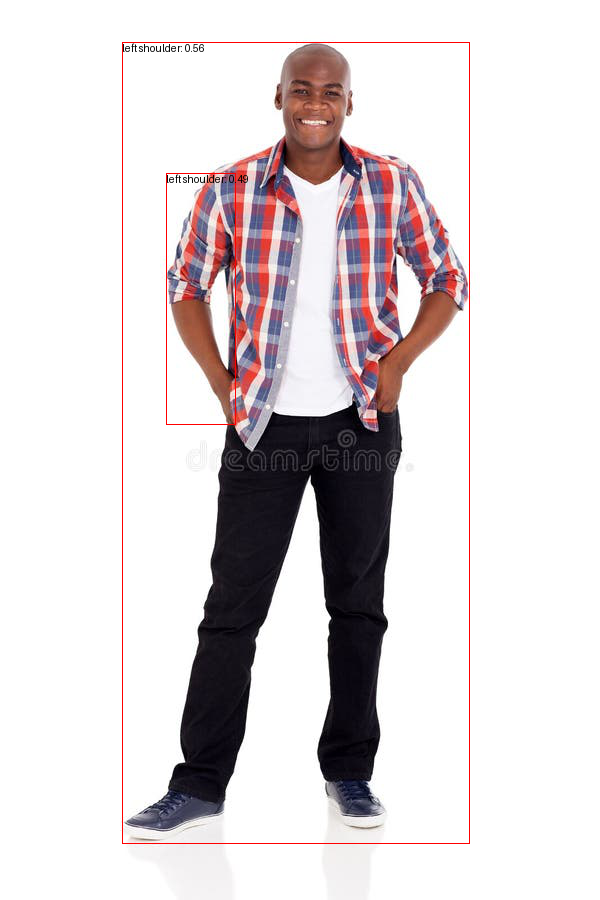

In [32]:
image # its not perfect because the model is small, but still :)

In [33]:
import torch
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from transformers.image_utils import load_image

processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

url = "https://thumbs.dreamstime.com/b/african-man-standing-happy-white-background-59852904.jpg"
image = load_image(url)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 05cad301-fa3e-4093-82d6-609dfe03eb2c)')' thrown while requesting HEAD https://huggingface.co/CIDAS/clipseg-rd64-refined/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [34]:
def predict_point(prompts):
    inputs = processor(
        text=prompts, images=[image] * len(prompts), padding=True, return_tensors="pt")

    with torch.inference_mode():
        outputs = model(**inputs)

    return outputs.logits.clone()

prompts = ["a left shoulder"]
logits = predict_point(prompts)

/home/jovyan/.mlspace/envs/flux-seminar/lib/python3.12/site-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


In [35]:
logits.shape, logits.min(), logits.max()

(torch.Size([1, 352, 352]), tensor(-10.4084), tensor(-0.6569))

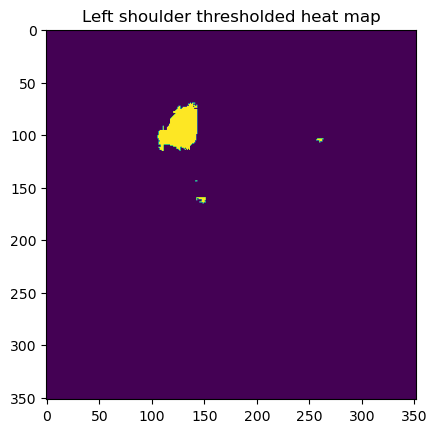

In [36]:
def norm_logits(logits):
    return (logits - logits.min()) / (logits.max() - logits.min())

logits = norm_logits(logits)

threshold = 0.95
plt.imshow(torch.where(logits.permute(1, 2, 0) > threshold, 1.0, 0.0))
plt.title('Left shoulder thresholded heat map');

In [37]:
def plot_images(prompts, logits, threshold=0.5):
    logits = logits.permute(1, 2, 0)
    
    fig, axs = plt.subplots(2, len(prompts), figsize=(10, 6))
    for i in range(len(prompts)):
        logits[..., i] = norm_logits(logits[..., i])
        axs[0][i].imshow(logits[..., i])
        axs[1][i].imshow(torch.where(logits[..., i] > threshold, 1.0, 0.0))
        
        axs[0][i].set_title(prompts[i])
        
    plt.tight_layout()

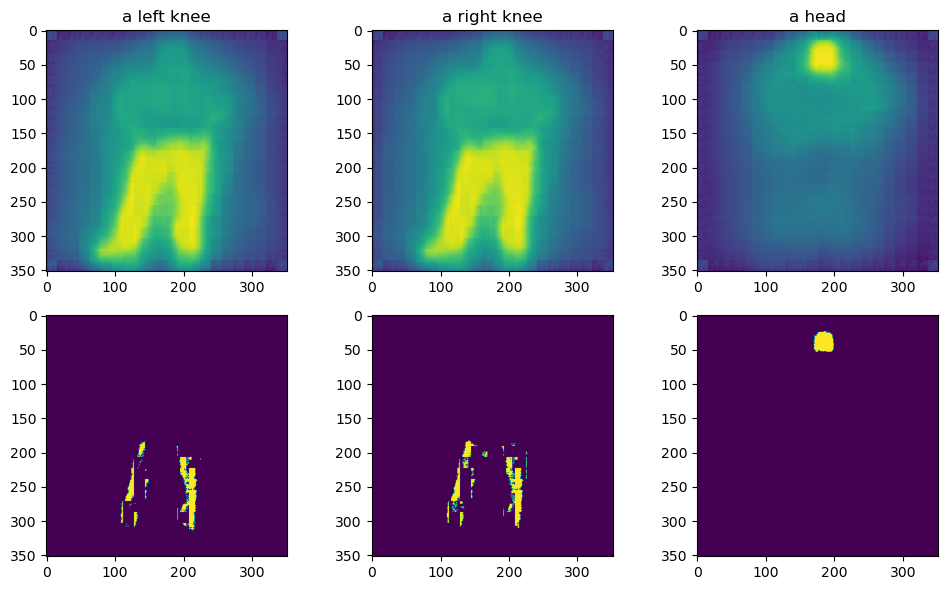

In [38]:
prompts = ["a left knee", "a right knee", "a head"]
logits = predict_point(prompts)

plot_images(prompts, logits, threshold=0.95)

# Mini DETR

We have talked a lot about [DETR](https://arxiv.org/abs/2005.12872) architecture. Today we want to create a small version of it to do a deeper dive on how it can be created. The code is based on a colab notebook provided by the authors, [link](https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb).

In [39]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [40]:
class minimalDETR(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [41]:
detr = minimalDETR(num_classes=91)

state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)

detr.load_state_dict(state_dict)
detr.eval();

/home/jovyan/.mlspace/envs/flux-seminar/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [42]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [43]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [44]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

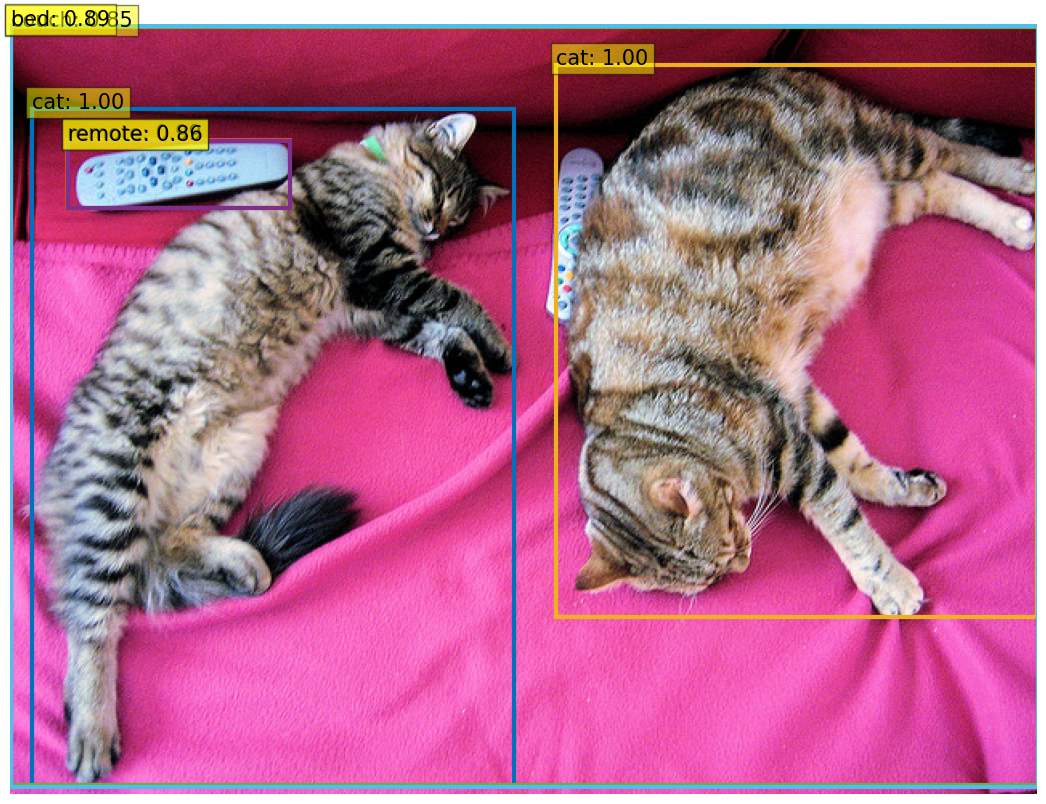

In [45]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, detr, transform)

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)